# Notebook to analyze Flight Delay dataset

dataset from kaggle: https://www.kaggle.com/datasets/hrishitpatil/flight-data-2024/data

The source `flight_dataset_2024.csv` contains columns of flight information including factors that were present and may have had to do with flights being delayed. That `.csv` had ~7 million rows. The dataset provider also included `flight_dataset_2024_sample.csv` which contains 10,000 rows. Analysis will be done on this sampled csv. Metadata that denotes what datatypes the columns are was stored in `flight_data_2024_data_dictionary.csv`.

In [138]:
# read the sampled flight delay dataset
flight_df = read.csv('flight_data_2024_sample.csv')
nrow(flight_df)

[1] 10000

In [139]:
# read column metadata
metadata_df = read.csv('flight_data_2024_data_dictionary.csv')
metadata_df

column,dtype,null_pct,example_value
year,Int64,0.00,2024
month,Int64,0.00,1
day_of_month,Int64,0.00,1
day_of_week,Int64,0.00,1
fl_date,datetime64[ns],0.00,2024-01-01 00:00:00
op_unique_carrier,object,0.00,9E
op_carrier_fl_num,float64,0.00,4814.0
origin,object,0.00,JFK
origin_city_name,object,0.00,"New York, NY"
origin_state_nm,object,0.00,New York


In [140]:
# omit any rows with NA's
clean_df = na.omit(flight_df)
nrow(flight_df) - nrow(clean_df)

[1] 164

We see that there were 164 out of the 10,000 rows that had NA's in them. The metadata shown above contains the percentages of NA's in each rows.
We will proceed with the remaining 9836 rows.

Currently, the arrival and departure `delay` columns are measured by how delayed the flight was in minutes where negative values denote if the flight was early. To simplify this, we will create new variables that will signify if a flight was delayed or not by inserting a '1' if the column value is non-zero positive and a '0' for negative and zero values.

In [141]:
# variables to track whether there was a delay or not by seeing whether there is a positive non-zero value 
arr_delay_bin = ifelse(clean_df$arr_delay > 0, 1, 0)

To get a sense of the data, we will start with a set of variables that logically are factors that are known before a flight takes place (otherwise predictors would contain answers for what they're trying to predict). Then variables will be chosen based on reducing multicollinearity. A correlation coefficent analysis will be produced.

In [142]:
desired_cols = c(
    "month",
    "day_of_week",
    "crs_arr_time",
    "crs_dep_time",
    "crs_elapsed_time",
    "distance"
)

In [143]:
# perform correlation test
corr_matrix = cor(clean_df[, desired_cols], )
print(round(corr_matrix, 3))

                  month day_of_week crs_arr_time crs_dep_time crs_elapsed_time
month             1.000       0.017        0.000       -0.017           -0.014
day_of_week       0.017       1.000       -0.014       -0.007            0.029
crs_arr_time      0.000      -0.014        1.000        0.706            0.026
crs_dep_time     -0.017      -0.007        0.706        1.000           -0.020
crs_elapsed_time -0.014       0.029        0.026       -0.020            1.000
distance         -0.008       0.028        0.025       -0.015            0.983
                 distance
month              -0.008
day_of_week         0.028
crs_arr_time        0.025
crs_dep_time       -0.015
crs_elapsed_time    0.983
distance            1.000


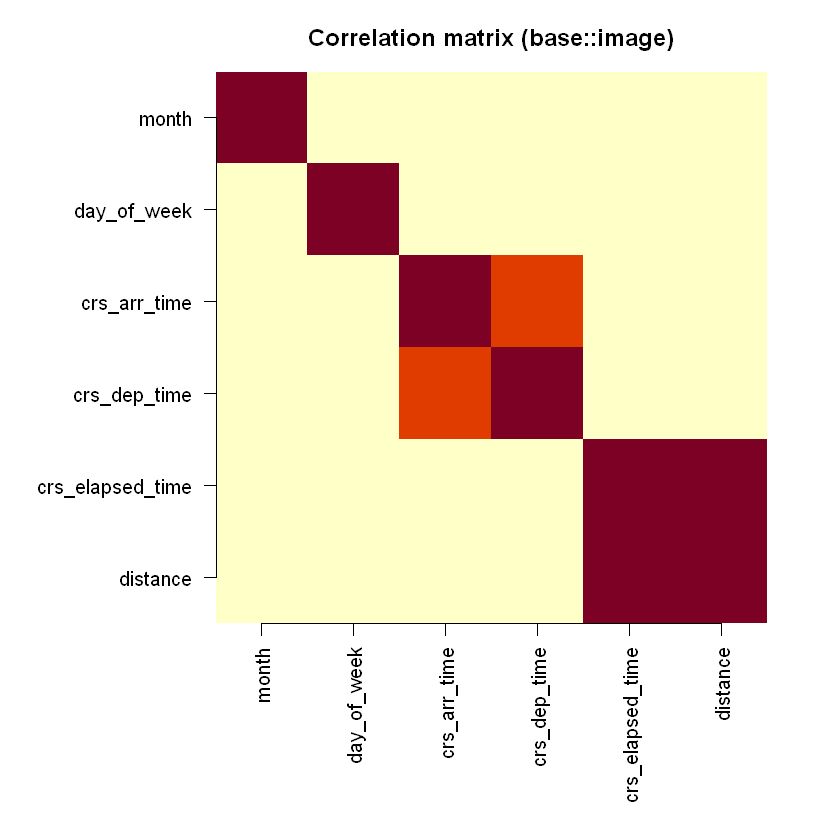

In [144]:
# Create a visualization for correlation
op = par(mar = c(9, 9, 3, 3))
image(1:ncol(corr_matrix), 1:ncol(corr_matrix), t(corr_matrix[ncol(corr_matrix):1, ]),
      axes = FALSE,
      xlab = "", ylab = "", main = "Correlation matrix (base::image)")
axis(1, at = 1:ncol(corr_matrix), labels = colnames(corr_matrix), las = 2)
axis(2, at = 1:ncol(corr_matrix), labels = rev(colnames(corr_matrix)), las = 2)
par(op)

We can see from both the produced matrix and image that there are variables that hare highly correlated with each other. The variable pair that had both a correlation of over 0.90 and light and dark red on the image was `crs_elapsed_time` and `distance`. For context, the prefix `crs` denotes the scheduled time; for example `crs_arr_time` is the scheduled arrival time whereas `arr_time` is the actual arrival time.

With these variables having high correlation with each other, to reduce multicollinearity, `distance` and will be removed as the `crs_elapsed_time` is calculated by the `distance`.

Because there are two types of delays, arrival and departure, for simplicity's sake, I will perform analysis on arrival only. 

## Arrival delay analysis: Logistic Regression

As a baseline, a logistic regression will be performed using the variable we created, `arr_delay_bin`, as the response, and 
`month`,
`day_of_week`,
`crs_arr_time`,
`crs_dep_time`,
`crs_elapsed_time`,
as the predictors. Using these predictors will allow us to see if there will be a delay in arrival or not. <br> 

Formally: <br>
Null Hypothesis: With Alpha at 0.01, none of the predictors will have a significant relationship with the response `arr_delay_bin`. <br>
Alternative Hypothesis: With Alpha at 0.01, at least one of the predictors will have a significant relationship with the response `arr_delay_bin`

In [145]:
# create logistic regression model
arr_model = glm(arr_delay_bin ~ crs_arr_time + crs_dep_time + crs_elapsed_time + month + day_of_week, data=clean_df, family = binomial)
summary(arr_model)


Call:
glm(formula = arr_delay_bin ~ crs_arr_time + crs_dep_time + crs_elapsed_time + 
    month + day_of_week, family = binomial, data = clean_df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.3208  -0.9670  -0.8213   1.3103   1.8103  

Coefficients:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)      -1.613e+00  1.017e-01 -15.867  < 2e-16 ***
crs_arr_time      1.390e-04  5.666e-05   2.453 0.014156 *  
crs_dep_time      5.182e-04  6.016e-05   8.613  < 2e-16 ***
crs_elapsed_time  6.337e-04  2.896e-04   2.188 0.028648 *  
month            -2.327e-02  6.290e-03  -3.700 0.000215 ***
day_of_week       5.199e-02  1.059e-02   4.910  9.1e-07 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 12896  on 9835  degrees of freedom
Residual deviance: 12645  on 9830  degrees of freedom
AIC: 12657

Number of Fisher Scoring iterations: 4


The residual deviance being lower than the null deviance is an indicator that the predictors add explanatory power to the model. The AIC is 13281.

We see that `crs_dep_time`, `month`, and `day_of_week` each had p-values that were less than 0.01 leading us to reject the null hypothesis. There was more than one predictor that had a significant relationship with `arr_delay_bin`. In other words, those predictors proved to have significance when a flight was delayed.

We can extend this model further to see what month and day of the week has the highest log-odds of delay.

In [157]:
# modify days_of_week to be a factor
clean_df$day_factor = factor(clean_df$day_of_week,
                              levels = 1:7,
                              labels = c("Mon","Tue","Wed","Thu","Fri","Sat","Sun"))

clean_df$month_factor = factor(clean_df$month,
                              levels = 1:12,
                              labels = c("Jan","Feb","Mar","Apr","May","Jun","Jul", "Aug", "Sep", "Oct", "Nov", "Dec"))

arr_model_ext = glm(arr_delay_bin ~ crs_arr_time + crs_dep_time + crs_elapsed_time + month_factor + day_factor,
                data = clean_df,
                family = binomial)

summary(arr_model_ext)



Call:
glm(formula = arr_delay_bin ~ crs_arr_time + crs_dep_time + crs_elapsed_time + 
    month_factor + day_factor, family = binomial, data = clean_df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.4832  -0.9595  -0.7910   1.2718   1.9985  

Coefficients:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)      -1.534e+00  1.230e-01 -12.475  < 2e-16 ***
crs_arr_time      1.495e-04  5.721e-05   2.613  0.00897 ** 
crs_dep_time      5.165e-04  6.073e-05   8.505  < 2e-16 ***
crs_elapsed_time  6.323e-04  2.926e-04   2.161  0.03068 *  
month_factorFeb  -4.920e-01  1.137e-01  -4.328 1.51e-05 ***
month_factorMar  -5.562e-02  1.059e-01  -0.525  0.59956    
month_factorApr  -1.568e-01  1.063e-01  -1.476  0.14002    
month_factorMay   6.579e-02  1.056e-01   0.623  0.53337    
month_factorJun   1.954e-02  1.059e-01   0.184  0.85363    
month_factorJul   3.307e-01  1.033e-01   3.202  0.00136 ** 
month_factorAug  -1.041e-01  1.055e-01  -0.988  0.32338  

In [ ]:
# higher value means higher log odds of 
aggregate(arr_delay_bin ~ day_factor, data=clean_df, mean)
aggregate(arr_delay_bin ~ month_factor, data=clean_df, mean)

day_factor,arr_delay_bin
Mon,0.3392157
Tue,0.3168605
Wed,0.3459168
Thu,0.3885602
Fri,0.3890049
Sat,0.3643471
Sun,0.4000000


month_factor,arr_delay_bin
Jan,0.3974895
Feb,0.2976023
Mar,0.3913043
Apr,0.3609467
May,0.4143378
Jun,0.4026764
Jul,0.4818594
Aug,0.3792299
Sep,0.2888087
Oct,0.2518757


The day that had the highest log odds was sunday and the lowest was Tuesday. The month that had the highest was July and the lowest was October. So booking a flight on a Tuesday in October has the least chance to have an arrival delay and the highest chance is a Sunday in July.

This extended model had a lower AIC than the original, so it will be used for further analysis.

### Model Variation

A new model will be created but only using the best performing variables from the first model.

In [110]:
# create logistic regression model
arr_model_2 = glm(arr_delay_bin ~ crs_dep_time + month + day_of_week, data=clean_df, family = binomial)
summary(arr_model_2)


Call:
glm(formula = arr_delay_bin ~ crs_dep_time + month + day_of_week, 
    family = binomial, data = clean_df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.3211  -0.9642  -0.8256   1.3129   1.8261  

Coefficients:
               Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -1.443e+00  8.701e-02 -16.586  < 2e-16 ***
crs_dep_time  6.169e-04  4.382e-05  14.076  < 2e-16 ***
month        -2.319e-02  6.286e-03  -3.689 0.000225 ***
day_of_week   5.228e-02  1.058e-02   4.943  7.7e-07 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 12896  on 9835  degrees of freedom
Residual deviance: 12656  on 9832  degrees of freedom
AIC: 12664

Number of Fisher Scoring iterations: 4


A third model will be produced with an interaction between month and day of the week.

In [111]:
# create logistic regression model
arr_model_3 = glm(arr_delay_bin ~ crs_dep_time + month*day_of_week, data=clean_df, family = binomial)
summary(arr_model_3)


Call:
glm(formula = arr_delay_bin ~ crs_dep_time + month * day_of_week, 
    family = binomial, data = clean_df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.3169  -0.9640  -0.8263   1.3125   1.8267  

Coefficients:
                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)       -1.425e+00  1.185e-01 -12.031   <2e-16 ***
crs_dep_time       6.170e-04  4.383e-05  14.078   <2e-16 ***
month             -2.597e-02  1.394e-02  -1.864   0.0624 .  
day_of_week        4.770e-02  2.307e-02   2.068   0.0387 *  
month:day_of_week  6.976e-04  3.123e-03   0.223   0.8232    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 12896  on 9835  degrees of freedom
Residual deviance: 12656  on 9831  degrees of freedom
AIC: 12666

Number of Fisher Scoring iterations: 4


The first model created had an AIC of 12657, the second had 12664, and the third had 12666. The models increasingly got worse after every iteration. The first model, also being the best model, will be used for further analysis.

### ANOVA of the models

In [114]:
# create anova test
anova(arr_model, arr_model_2, arr_model_3, test = "Chisq")

Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
9830,12645.00,NA,NA,NA
9832,12656.25,-2,-11.25247611,0.003602101
9831,12656.20,1,0.04990846,0.823222636


The second model, `arr_model_2`, had a greater residual deviance than `arr_model` and had a negative deviance difference big enough to be statistically significant from `arr_model`, ultimately making `arr_model_2` a worse model. The third model, `arr_model_3`, was not significant from `arr_model_2`, so there was no improvement to be noted.
This ANOVA test further strengthens the conclusion of `arr_model` being the best performing model.

### Odds ratio and Cook's Distance

In [113]:
# create odds ratio table
coef_table = cbind(Estimate = coef(arr_model),
                   OddsRatio = exp(coef(arr_model)))
round(coef_table, 3)

,Estimate,OddsRatio
(Intercept),-1.613,0.199
crs_arr_time,0.000,1.000
crs_dep_time,0.001,1.001
crs_elapsed_time,0.001,1.001
month,-0.023,0.977
day_of_week,0.052,1.053


We can see that `crs_arr_time`,  `crs_dep_time`,  and `crs_elapsed_time` all had an OddsRatio of 1 or 1.001, meaning no significant effect on predicting whether there was an arrival delay or not. On the other hand, though, `month` and `day_of_week` had 0.977 and 1.053 OddsRatios, respectively. While `month` had lower odds of predicting an arrival delay, `day_of_week` by far had the highest odds of predict arrival delay.

[1] 315

[1] 0.03202521

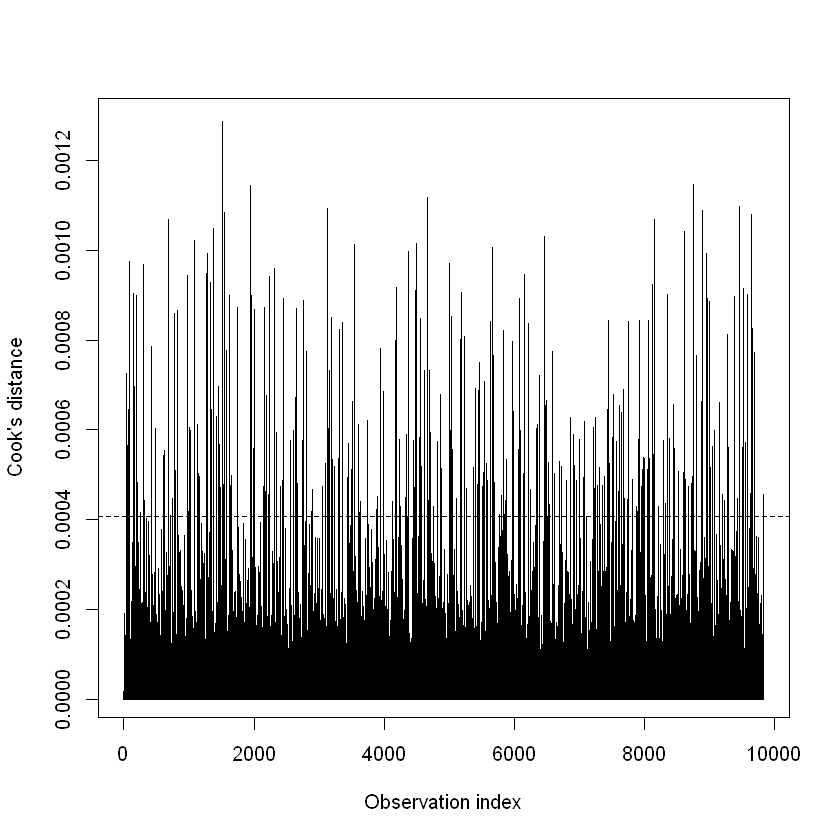

In [128]:
# create cooks distance plot
cd = cooks.distance(arr_model)
plot(cd, type = "h", xlab = "Observation index", ylab = "Cook's distance")
abline(h = 4 / nrow(clean_df), lty = 2)

# number of points that pass Cooks distance
length(which(cd > 4 / nrow(clean_df))) 
# percentage of clean_df 
length(which(cd > 4 / nrow(clean_df))) / nrow(clean_df)

We can see a plot of Cook's Distance and a visualization of the points that surpass that threshold. A concrete percentage of the entire data that surpasses Cook's Distance is about 3.2%. 

### ROC curve, AUC, and accuracy analysis

In [44]:
# install.packages("pROC")
library(pROC)

Area under the curve: 0.5961

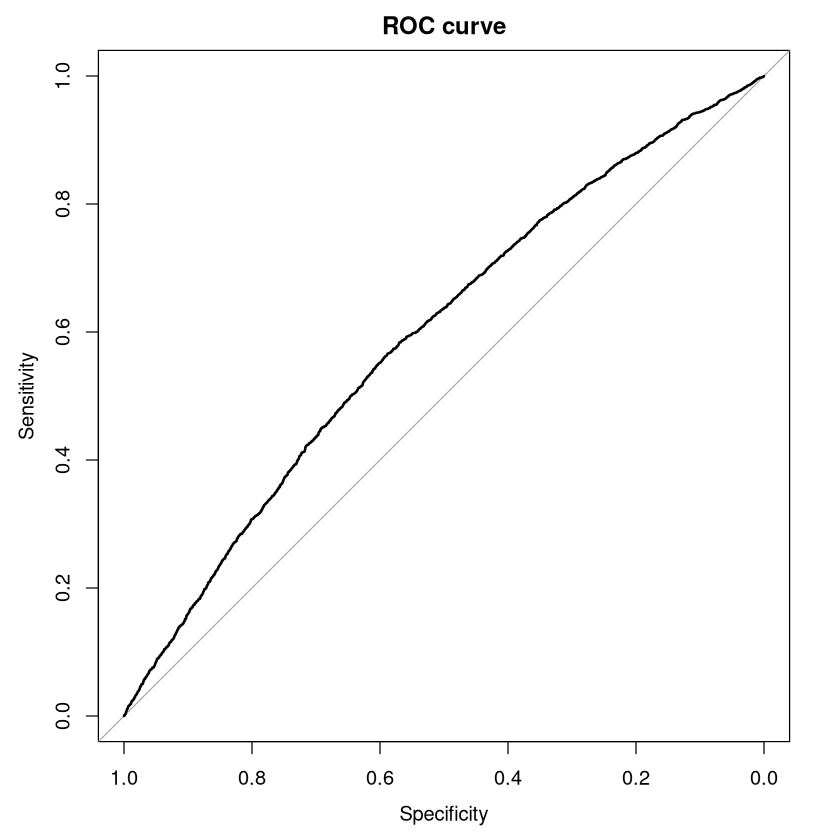

In [45]:
p_hat = predict(arr_model)

roc_obj = roc(response=arr_delay_bin, predictor=p_hat, quiet=TRUE)
plot(roc_obj, main = "ROC curve")
auc(roc_obj)

An AUC of ~0.60 tells us that the model performed slightly better than random 50/50 guessing. It can be concluded that from this model it is hard to tell whether a flight was actually delayed.

A confusion matrix of TP, TN, FP, FN counts can now be produced.

In [46]:
# threshold of 0.5
theta = 0.5
y_hat = ifelse(p_hat >= theta, 1, 0)
conf_matrix = table(Actual = arr_delay_bin, Predicted = y_hat)

In [47]:
# threshold of 0.30
theta = 0.30
y_hat = ifelse(p_hat >= theta, 1, 0)
conf_matrix_30 = table(Actual = arr_delay_bin, Predicted = y_hat)

Using a threshold of 0.5, we see the number of false negatives was 3435, over 3000 counts more than the amount of true negatives and false positives. When a threshold of 0.30 was used, though, the number of false positives was 4540. In context of the data, a false negative means that a flight was not predicted to be delayed but turned out to be delayed in reality whereas a false positive means that a flight was predicted to be delayed but turned out to not be in reality. In practice, a threshold of 0.30 would be more desirable because a person would be a lot less upset if they were expecting there to be an arrival delay but the plane lands on time.

In [55]:
# find accuracy
accuracy = sum(diag(conf_matrix) / sum(conf_matrix))
accuracy_30 = sum(diag(conf_matrix_30) / sum(conf_matrix_30))

# compute sensitivity and specificity
tp = conf_matrix["1","1"]
tn = conf_matrix["0","0"]
fp = conf_matrix["0","1"]
fn = conf_matrix["1","0"]

tp_30 = conf_matrix_30["1","1"]
tn_30 = conf_matrix_30["0","0"]
fp_30 = conf_matrix_30["0","1"]
fn_30 = conf_matrix_30["1","0"]

sensitivity = tp / (tp + fn)  # recall for class 1
specificity = tn / (tn + fp)

sensitivity_30 = tp_30 / (tp_30 + fn_30)  # recall for class 1
specificity_30 = tn_30 / (tn_30 + fp_30)
c(accuracy = accuracy, sensitivity = sensitivity, specificity = specificity)
c(accuracy = accuracy_30, sensitivity = sensitivity_30, specificity = specificity_30)

accuracy sensitivity specificity 
 0.63603091  0.03996646  0.97682966

accuracy sensitivity specificity 
  0.4770232   0.8311906   0.2745286

Using a threshold of 0.50, the sensitivity was ~3.9% and the specificity was ~97%. Using a threshold of 0.30, the sensitivity was ~83% and the specificity was ~27%. The accuracy of using a threshold 0.50 was 63% while threshold 0.3 was 47%. Accuracy is lost when trying to appeal to the more realistically desirable threshold, 0.30.